In [5]:
import sys
import os
notebook_dir = os.getcwd()
src_path = os.path.abspath(os.path.join(notebook_dir, 'src'))
sys.path.append(src_path)
from loguru import logger
from src.utils import get_objects_and_occlusion_levels, load_json, generate_histogram
import pandas as pd



In [ ]:
def map_occlusion_level_to_category(occlusion_level: float) -> str:
    if occlusion_level <= 0.25:
        return 'No to slight occlusion'
    elif occlusion_level <= 0.5:
        return 'Moderate occlusion'
    elif occlusion_level <= 0.75:
        return 'Heavy occlusion'
    elif occlusion_level <= 1.0:
        return 'Extreme occlusion'
    else:
        raise ValueError(f"Invalid occlusion level: {occlusion_level}. Must be between 0 and 1.")

def process_annotation_files(directory_path: str) -> None:
    """
    Loops over all annotation files in the FashionVeil directory, loads them,
    and save the objects and occlusion levels as a CSV file.

    Args:
        directory_path (str): The path to the directory containing the annotation files (.json).
    
    Returns:
        None
    """
    annotation_details = []
    output_path = 'fashionveil_objects_occlusion.csv'
    for entry in os.scandir(directory_path):
        if entry.is_file() and entry.name.endswith('.json'):
            file_path = entry.path
            file_name = entry.name
            annotation_file_dict = load_json(file_path)
            objects_with_occlusions_levels = get_objects_and_occlusion_levels(annotation_file_dict)
            
            for obj_label, occ_level in objects_with_occlusions_levels:
                annotation_details.append({
                    'file_name': file_name,
                    'object': obj_label,
                    'occlusion_level': map_occlusion_level_to_category(occ_level)
                })


    df_objects_occlusion = pd.DataFrame(annotation_details)
    df_objects_occlusion.to_csv(output_path, index=False)
    logger.info(f"Saved objects and occlusion levels to {output_path}")

process_annotation_files('curate_xanylabeling_annotations/FashionVeil/')

2025-05-28 11:36:24.135 | INFO     | __main__:process_annotation_files:43 - Saved objects and occlusion levels to fashionveil_objects_occlusion.csv


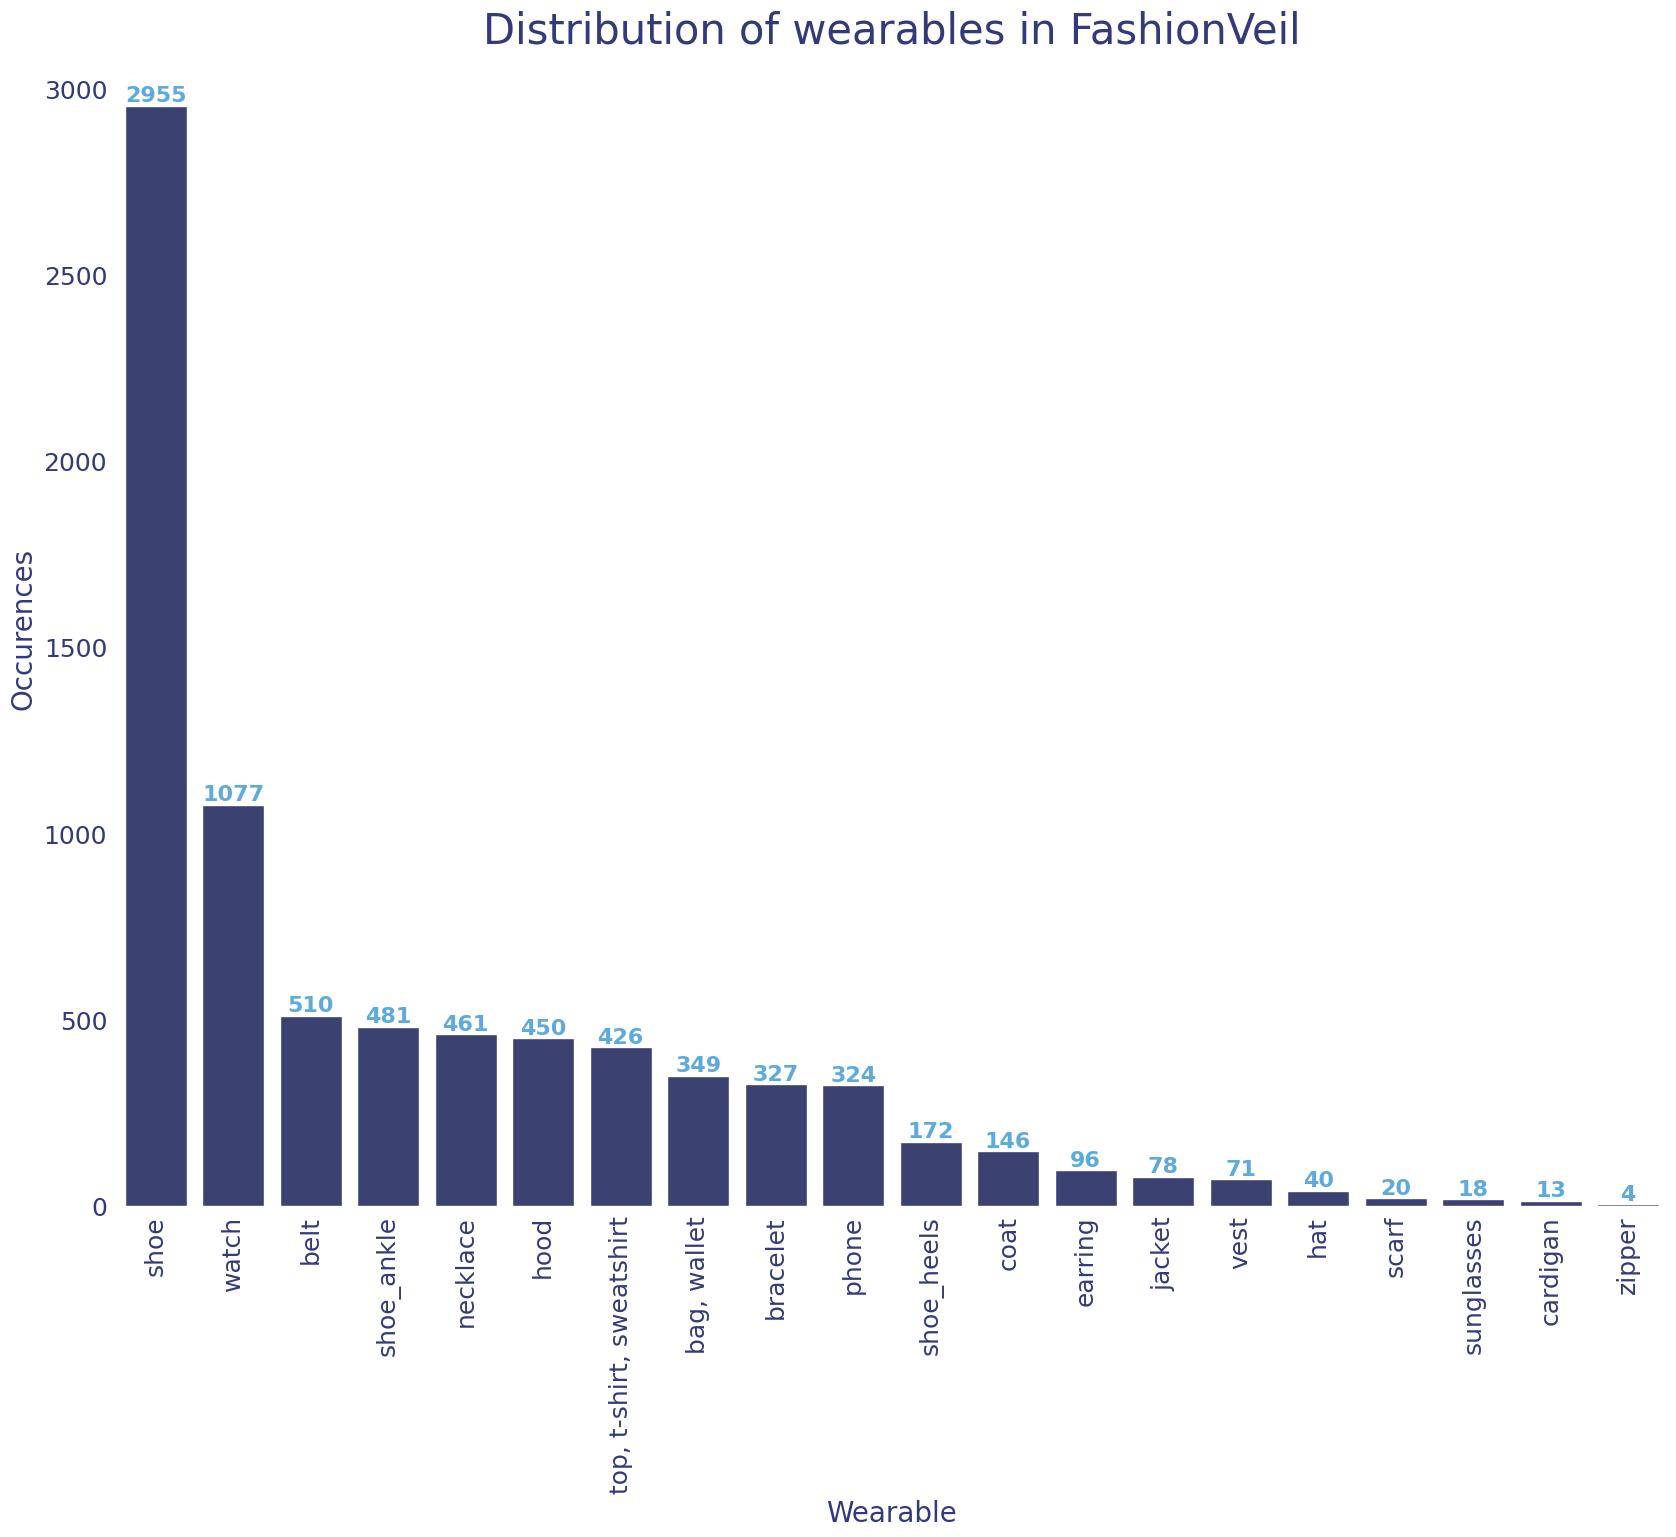

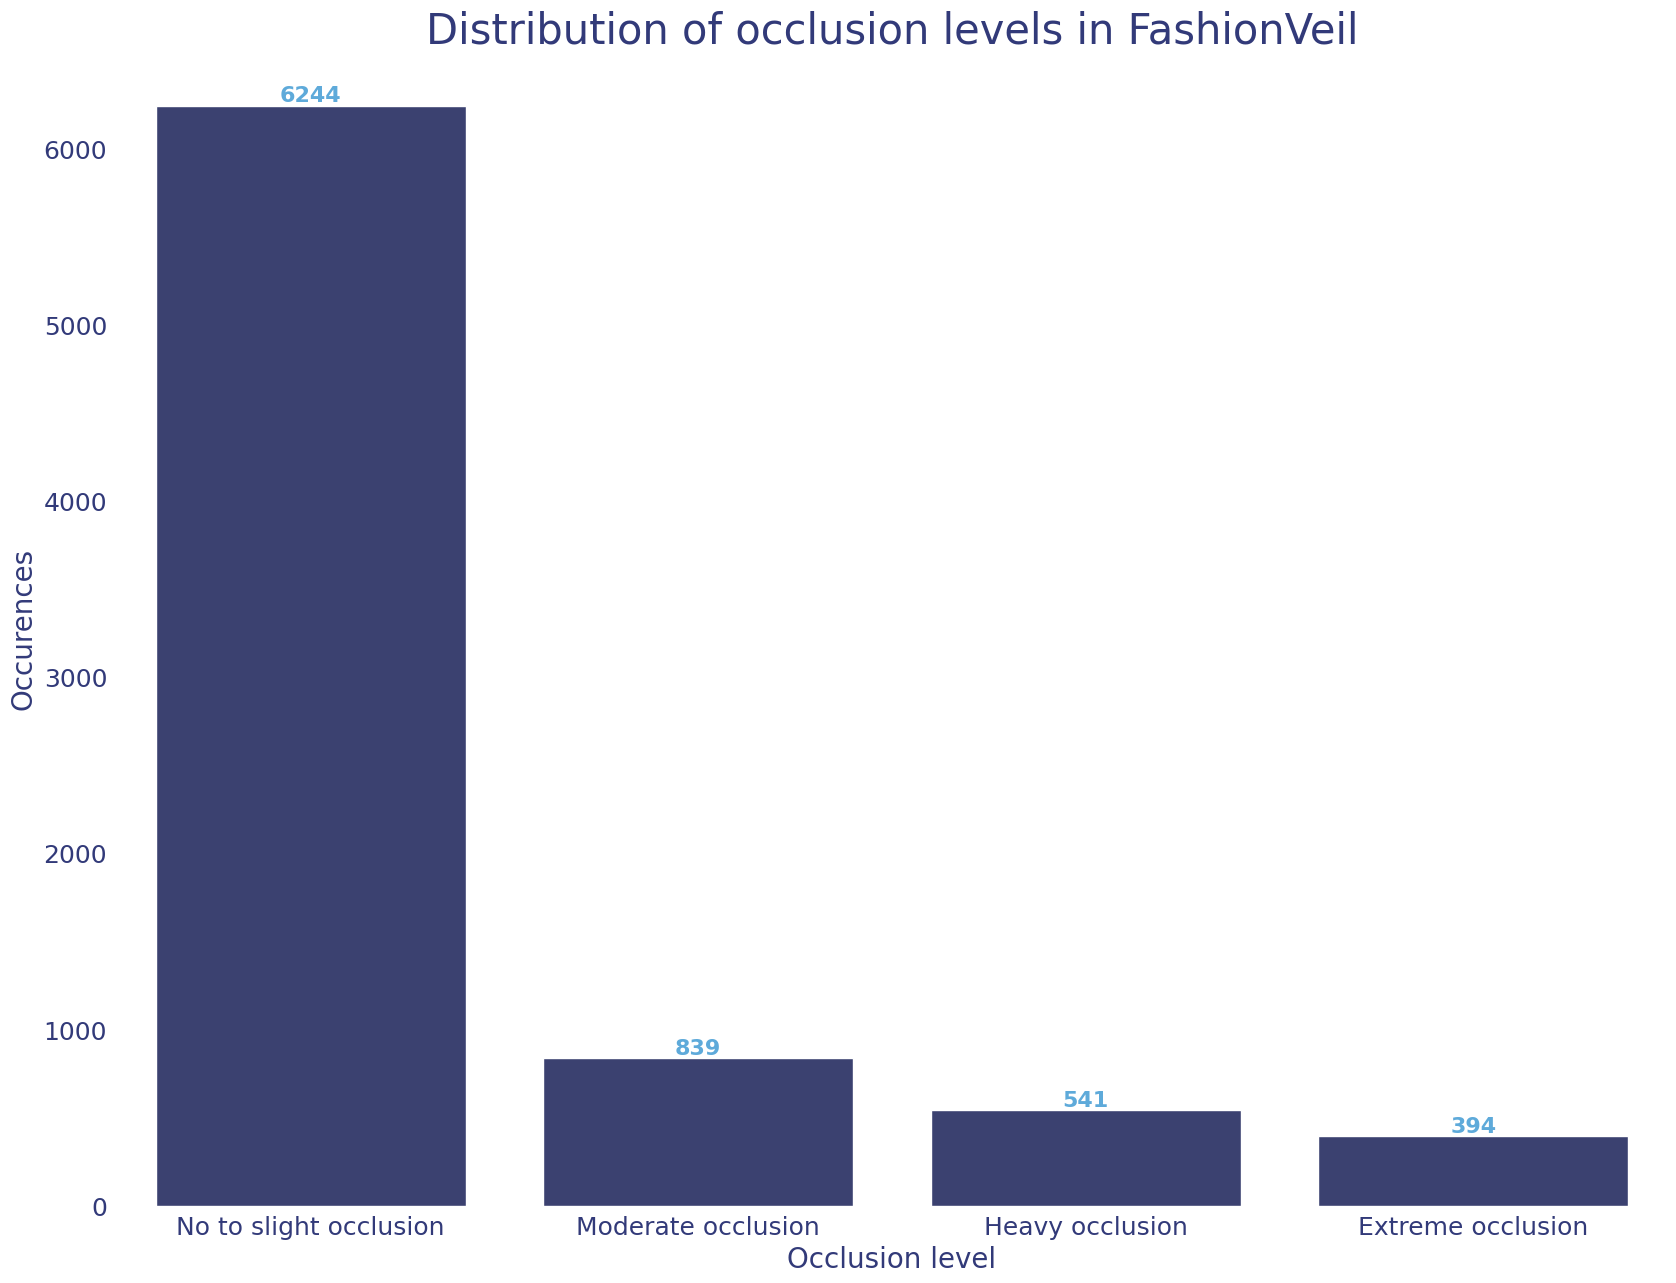

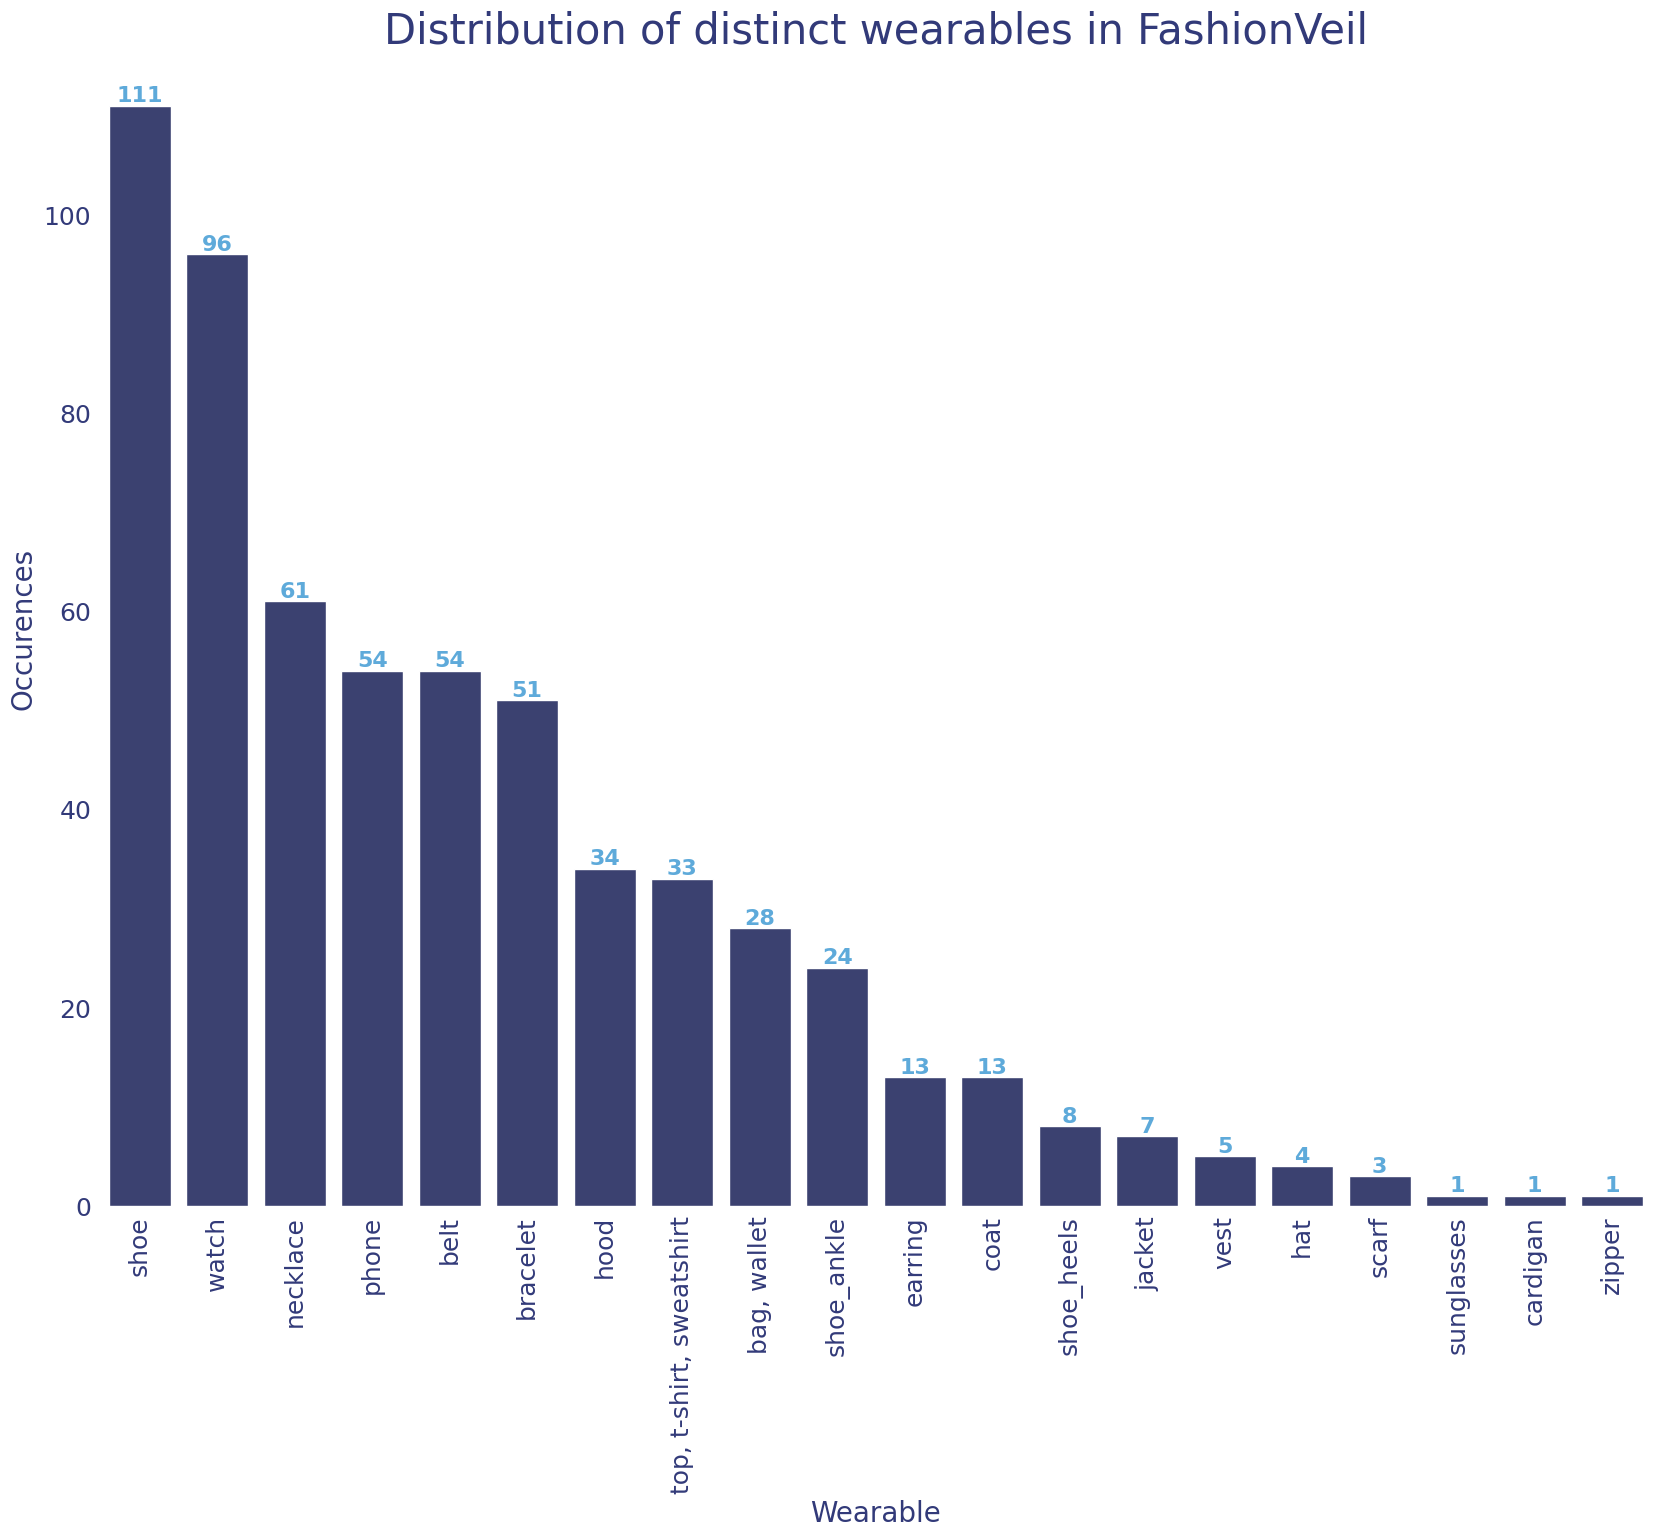

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

annotation_data = pd.read_csv('fashionveil_objects_occlusion.csv')
object_counts = annotation_data['object'].value_counts().reset_index()
occlusion_level_counts = annotation_data['occlusion_level'].value_counts().reset_index()
annotation_data['file_name_prefix'] = annotation_data['file_name'].apply(lambda name: name.split('_')[0])

distinct_object_counts = annotation_data.drop_duplicates(subset=['object', 'file_name_prefix']).drop(['file_name', 'occlusion_level', 'file_name_prefix'],axis=1).value_counts().reset_index()
distinct_object_counts.to_excel('fashionveil_distinct_objects.xlsx', index=False)

generate_histogram(object_counts, 'object', 'count','Distribution of wearables in FashionVeil', 'Wearable','Occurences', 'fashionveil_objects_histogram', rotation=90)
generate_histogram(occlusion_level_counts, 'occlusion_level', 'count','Distribution of occlusion levels in FashionVeil', 'Occlusion level','Occurences', 'fashionveil_occlusion_histogram', rotation=0)
generate_histogram(distinct_object_counts, 'object', 'count','Distribution of distinct wearables in FashionVeil', 'Wearable','Occurences', 'fashionveil_distinct_objects_histogram', rotation=90)



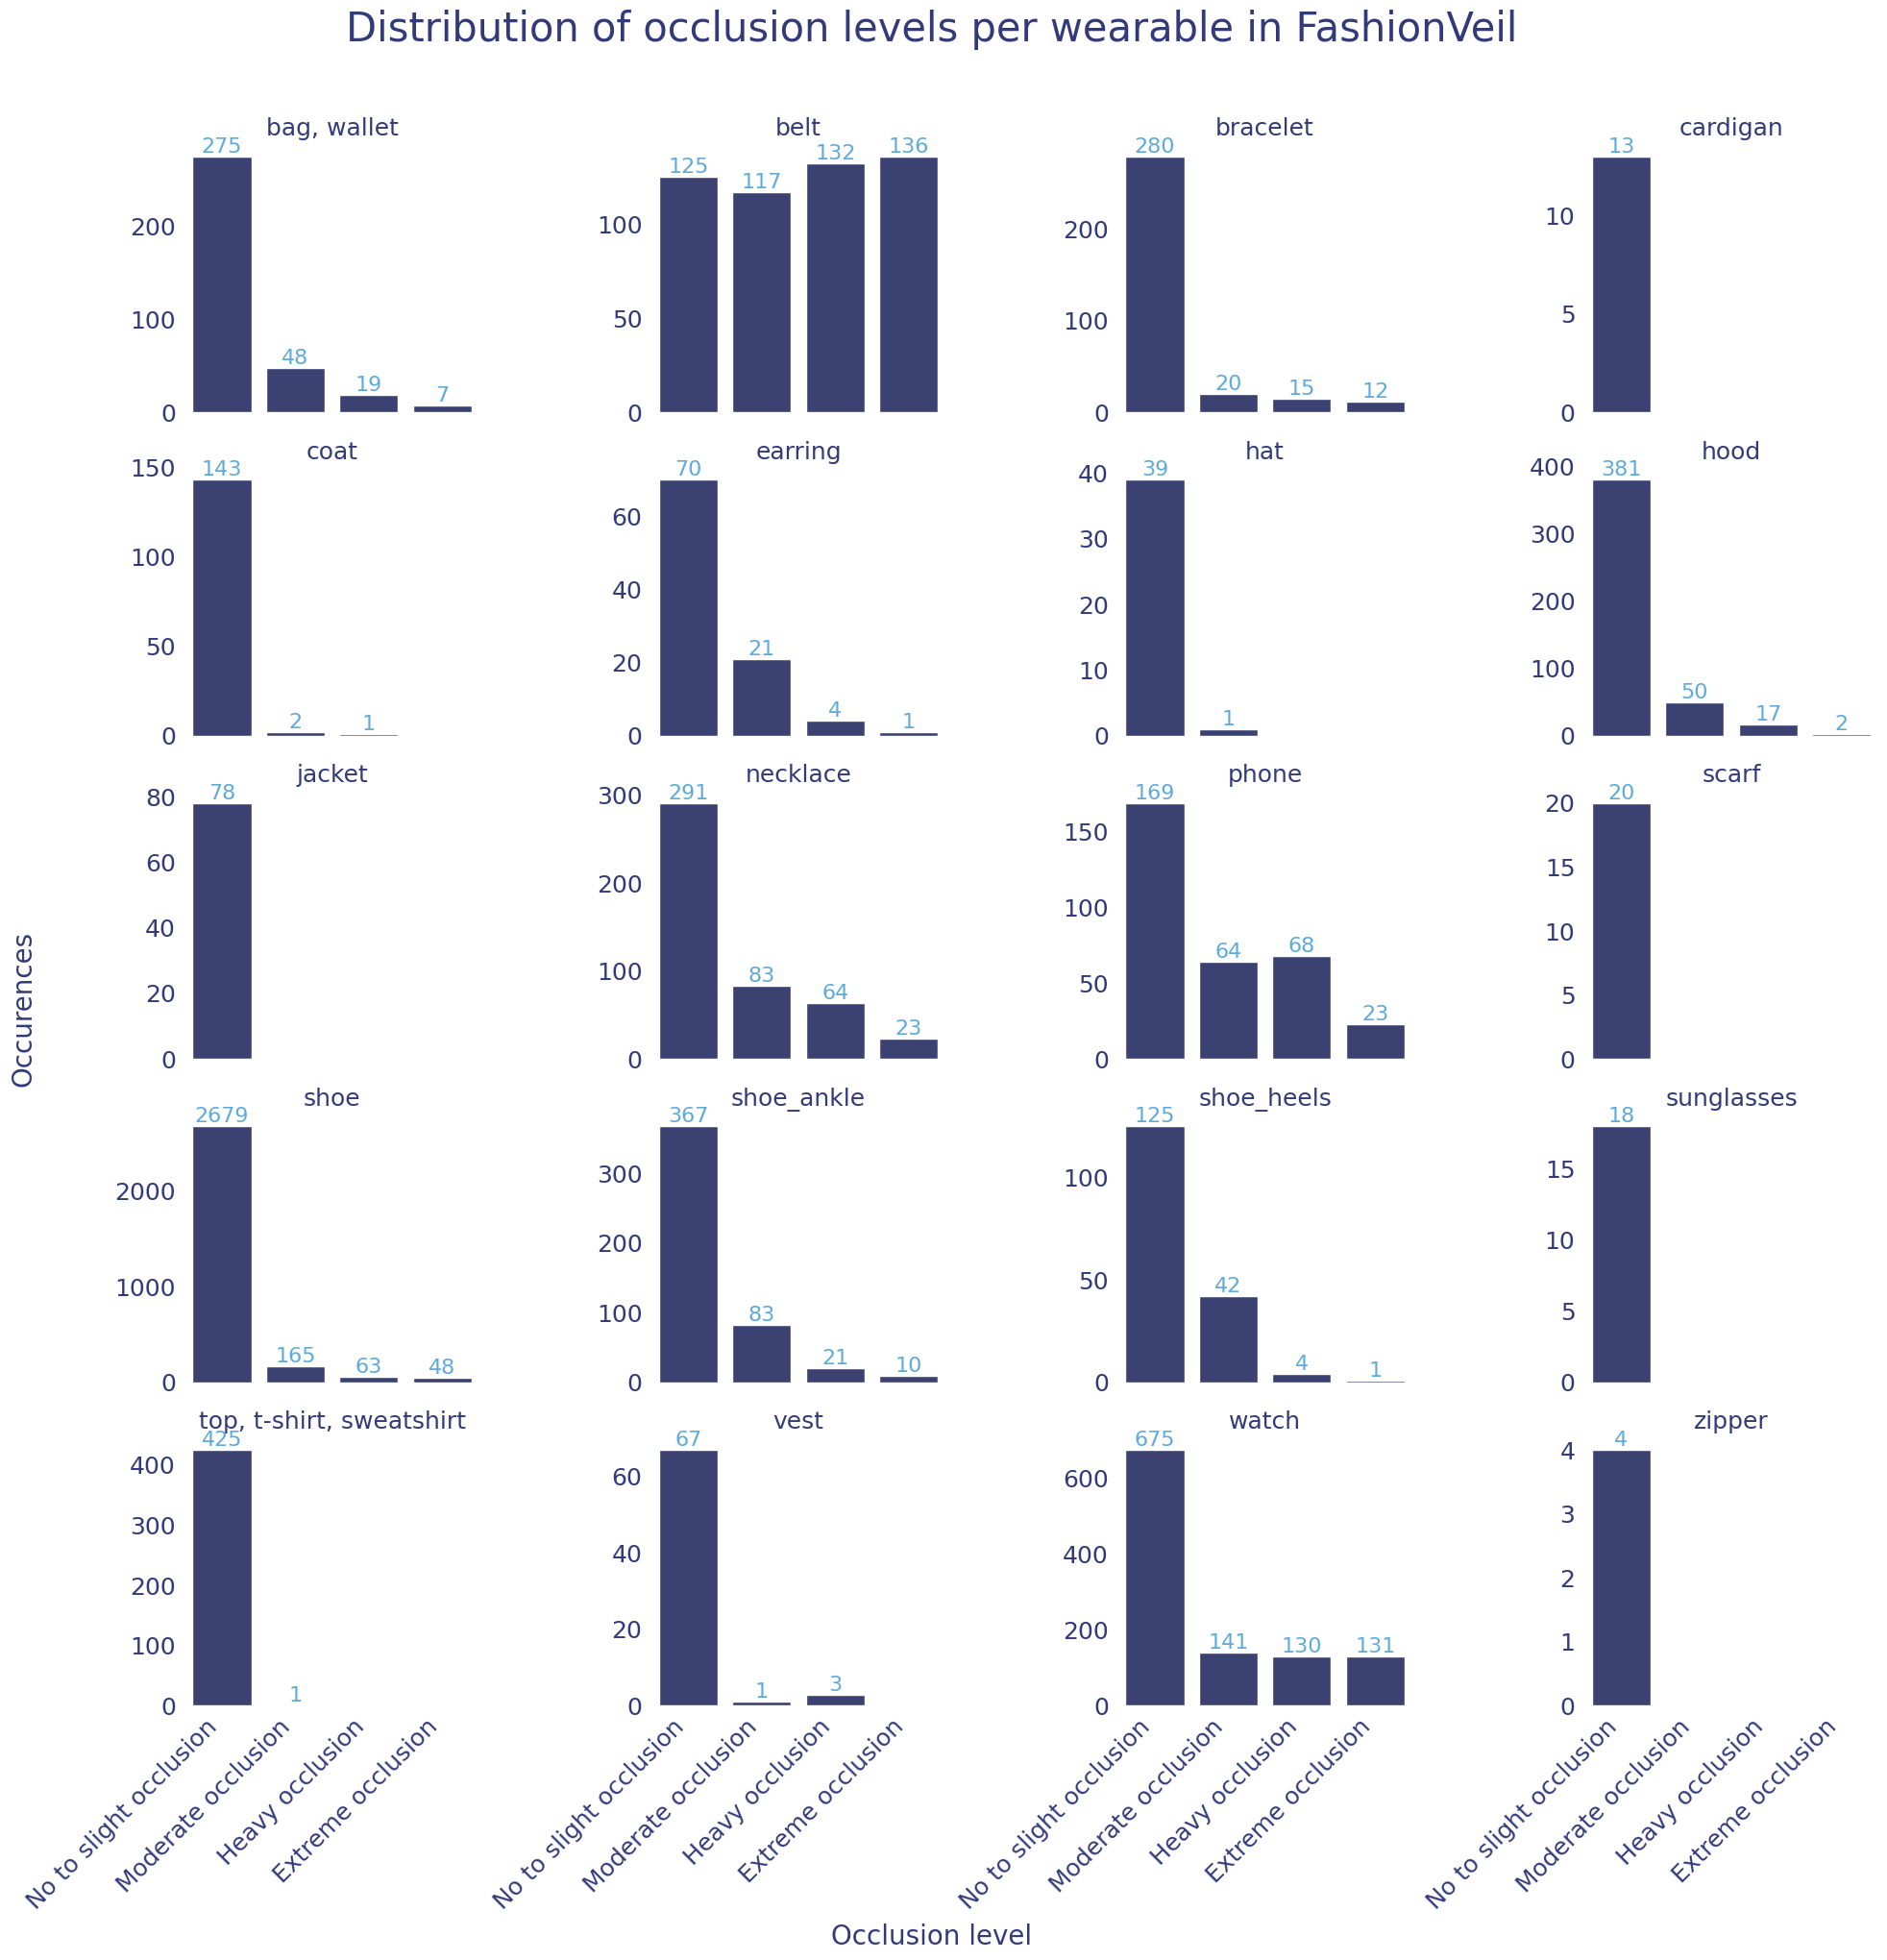

In [20]:
colors = {
    "primary_dark": "#323a79",
    "primary_light": "#5EAADA",
    "white": "#ffffff",
}
sns.set_style("white")

occlusion_order = ['No to slight occlusion', 'Moderate occlusion', 'Heavy occlusion', 'Extreme occlusion']

unique_objects = annotation_data['object'].nunique()
n_cols = 4
n_rows = (unique_objects + n_cols - 1) // n_cols

fig = plt.figure(figsize=(5 * n_cols, 4 * n_rows)) 

for i, (object_name, group) in enumerate(annotation_data.groupby('object')):
    # Calculate current row and column
    current_row = i // n_cols
    current_col = i % n_cols
    
    ax = plt.subplot(n_rows, n_cols, i + 1)
    countplot = sns.countplot(data=group, x='occlusion_level', order=occlusion_order, color=colors["primary_dark"], ax=ax)

    for p in countplot.patches:
        countplot.annotate(f'{int(p.get_height())}',
                           (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha='center', va='bottom',
                           color=colors["primary_light"], 
                           fontsize=16, fontweight='normal')

    ax.set_title(object_name, fontsize=18, color=colors["primary_dark"])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(colors=colors["primary_dark"], labelsize=18)
    
    # Only show x-tick labels for the last row or for plots in positions where there won't be a plot beneath
    is_last_row = (current_row == n_rows - 1)
    is_last_in_col = (current_row * n_cols + current_col >= unique_objects - n_cols)
    
    if is_last_row or is_last_in_col:
        plt.setp(ax.get_xticklabels(), visible=True, rotation=45, ha='right', fontsize=18)
    else:
        plt.setp(ax.get_xticklabels(), visible=False)
    
    for spine in ax.spines.values():
        spine.set_visible(False)

fig.suptitle('Distribution of occlusion levels per wearable in FashionVeil', fontsize=30, color=colors["primary_dark"], y=1.02)
fig.supxlabel('Occlusion level', fontsize=20, color=colors["primary_dark"])
fig.supylabel('Occurences', fontsize=20, color=colors["primary_dark"])
plt.tight_layout()
plt.savefig('fashionveil_occlusion_levels_per_object.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [1]:
import json

def merge_coco_json(json1_path, json2_path, output_path):
    with open(json1_path, 'r') as f1, open(json2_path, 'r') as f2:
        coco1 = json.load(f1)
        coco2 = json.load(f2)

    # Make sure categories are the same or merge if needed
    categories = coco1['categories']

    # Offset image and annotation IDs in the second file
    max_img_id = max(img['id'] for img in coco1['images'])
    max_ann_id = max(ann['id'] for ann in coco1['annotations'])

    for img in coco2['images']:
        img['id'] += max_img_id + 1

    for ann in coco2['annotations']:
        ann['id'] += max_ann_id + 1
        ann['image_id'] += max_img_id + 1

    merged = {
        'images': coco1['images'] + coco2['images'],
        'annotations': coco1['annotations'] + coco2['annotations'],
        'categories': categories
    }

    with open(output_path, 'w') as f:
        json.dump(merged, f)

merge_coco_json('instances_attributes_train2020.json', 'instances_attributes_val2020.json', 'fashionpedia.json')

In [5]:
from pycocotools.coco import COCO

# Load the COCO annotation file
coco = COCO('FashionVeil_coco.json')

# Total number of annotations (objects)
total_objects = len(coco.getAnnIds())

# Total number of images
total_images = len(coco.getImgIds())

# Average number of objects per image
avg_objects_per_image = total_objects / total_images

print(f"Average number of objects per image: {avg_objects_per_image:.2f}")


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Average number of objects per image: 4.21


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=2.08s)
creating index...
index created!


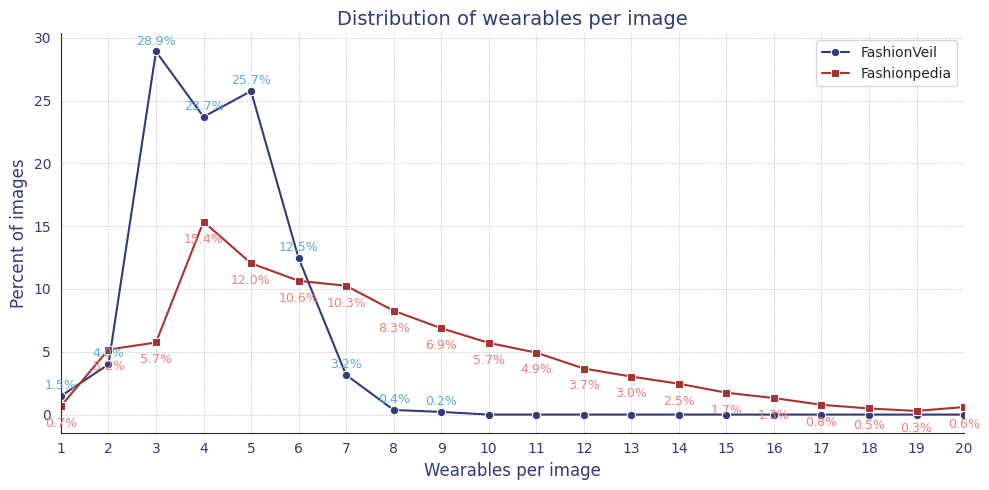

In [4]:
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def get_object_count_distribution(annotation_file, max_objects=20):
    coco = COCO(annotation_file)
    img_ids = coco.getImgIds()
    object_counts = [
        len(coco.getAnnIds(imgIds=img_id, iscrowd=None))
        for img_id in img_ids
    ]
    # Cap counts at max_objects
    capped_counts = [count if count <= max_objects else max_objects for count in object_counts]
    df = pd.DataFrame({"object_count": capped_counts})
    count_freq = df['object_count'].value_counts().sort_index()
    # Ensure all bins from 1 to max_objects are present
    all_bins = pd.Series(0, index=range(1, max_objects + 1))
    count_freq = all_bins.add(count_freq, fill_value=0)
    x_vals = count_freq.index
    y_vals = (count_freq / len(df)) * 100  # percentage
    return x_vals, y_vals

# Colors and style
colors = {
    "primary_dark": "#323a79",
    "primary_light": "#5EAADA",
    "secondary_dark": "#A83232",
    "secondary_light": "#F08080",
    "white": "#ffffff",
}
sns.set_style("white")

# Get distributions with cutoff at 20
x1, y1 = get_object_count_distribution('FashionVeil_coco.json', max_objects=20)
x2, y2 = get_object_count_distribution('fashionpedia.json', max_objects=20)

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x=x1, y=y1, marker='o', color=colors["primary_dark"], ax=ax, label='FashionVeil')
sns.lineplot(x=x2, y=y2, marker='s', color=colors["secondary_dark"], ax=ax, label='Fashionpedia')

# Annotate points for both datasets
for x, y in zip(x1, y1):
    if y > 0:
        ax.annotate(f'{y:.1f}%', (x, y), textcoords="offset points", xytext=(0, 5),
                    ha='center', fontsize=9, color=colors["primary_light"])
for x, y in zip(x2, y2):
    if y > 0:
        ax.annotate(f'{y:.1f}%', (x, y), textcoords="offset points", xytext=(0, -15),
                    ha='center', fontsize=9, color=colors["secondary_light"])

# Styling
ax.set_xlabel('Wearables per image', fontsize=12, color=colors["primary_dark"])
ax.set_ylabel('Percent of images', fontsize=12, color=colors["primary_dark"])
ax.set_title('Distribution of wearables per image', fontsize=14, color=colors["primary_dark"])
ax.tick_params(colors=colors["primary_dark"])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
ax.set_xlim(1, 20)  # Set x-axis limit to 1-20
ax.set_xticks(range(1, 21))  # Label x-axis 1 through 20
plt.tight_layout()
plt.savefig('objects_per_image_distribution_comparison.pdf')
plt.show()

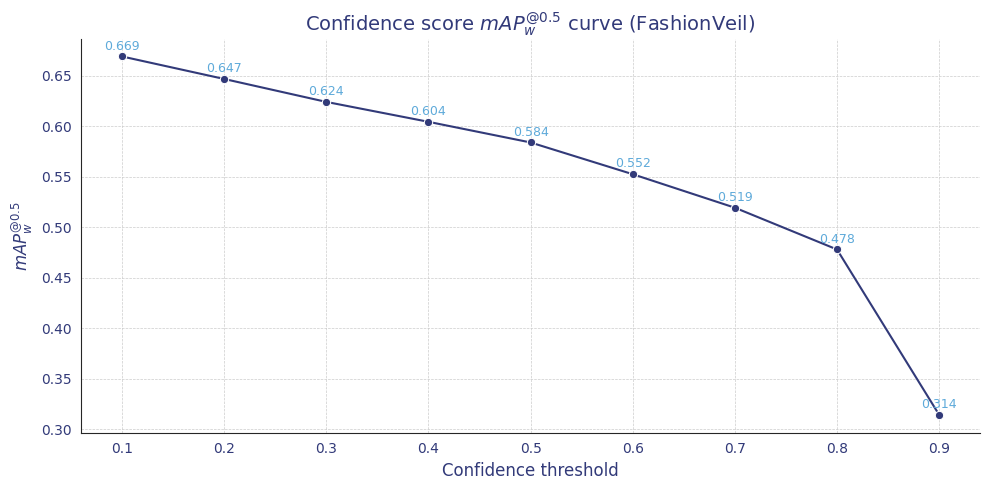

In [3]:

# Prepare DataFrame for plotting
df = pd.read_csv("rfdetr.csv")

# Custom styling
colors = {
    "primary_dark": "#323a79",
    "primary_light": "#5EAADA",
    "white": "#ffffff",
}
sns.set_style("white")


fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x=df["confidence_threshold"], y=df["wmap50"], marker='o', color=colors["primary_dark"], ax=ax)

# Annotate points
for x, y in zip(df["confidence_threshold"], df["wmap50"]):
    ax.annotate(f'{y:.3f}', (x, y), textcoords="offset points", xytext=(0, 5),
                ha='center', fontsize=9, color=colors["primary_light"])

# Styling
ax.set_xlabel('Confidence threshold', fontsize=12, color=colors["primary_dark"])
ax.set_ylabel('$mAP_w^{@0.5}$', fontsize=12, color=colors["primary_dark"])
ax.set_title('Confidence score $mAP_w^{@0.5}$ curve (FashionVeil)', fontsize=14, color=colors["primary_dark"])
ax.tick_params(colors=colors["primary_dark"])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('confmap_curve_fashionveil.pdf')
plt.show()

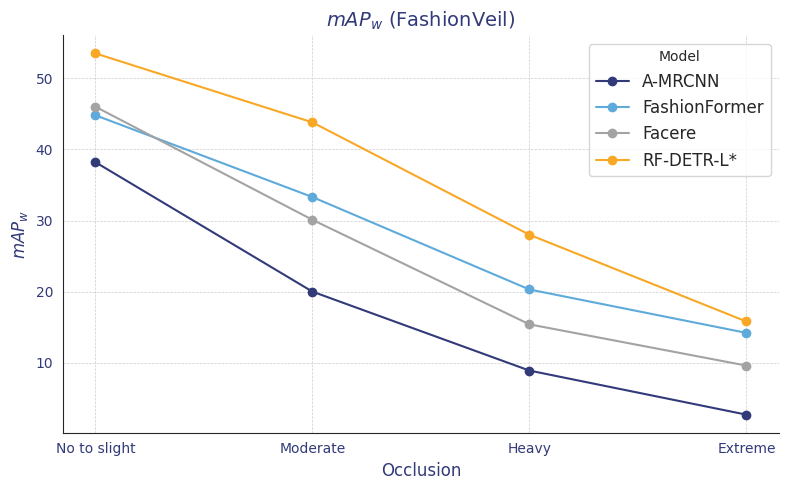

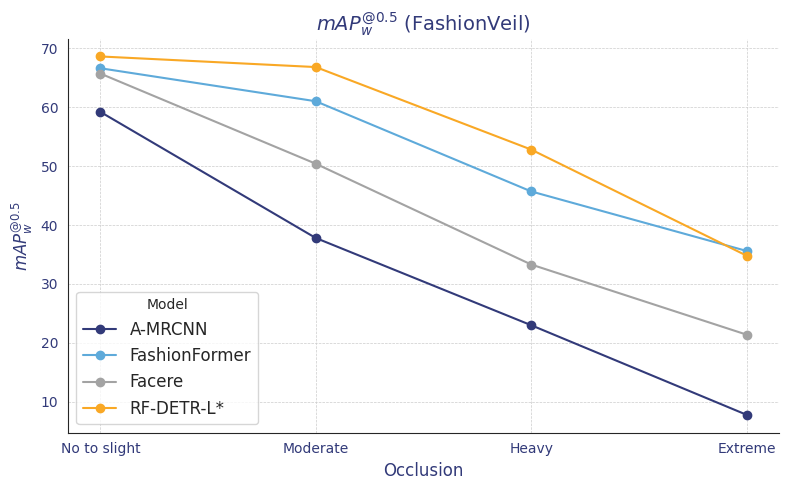

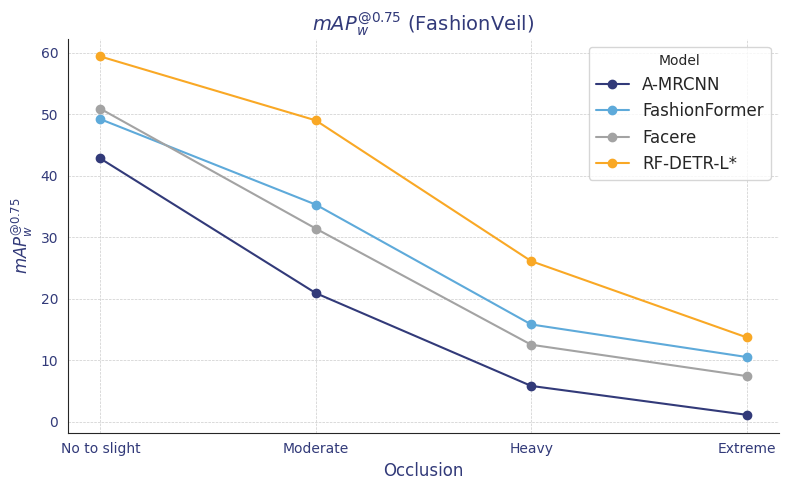

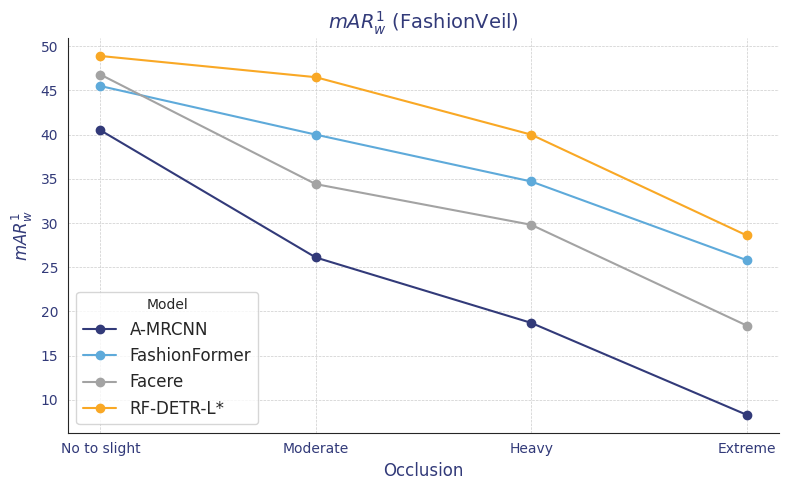

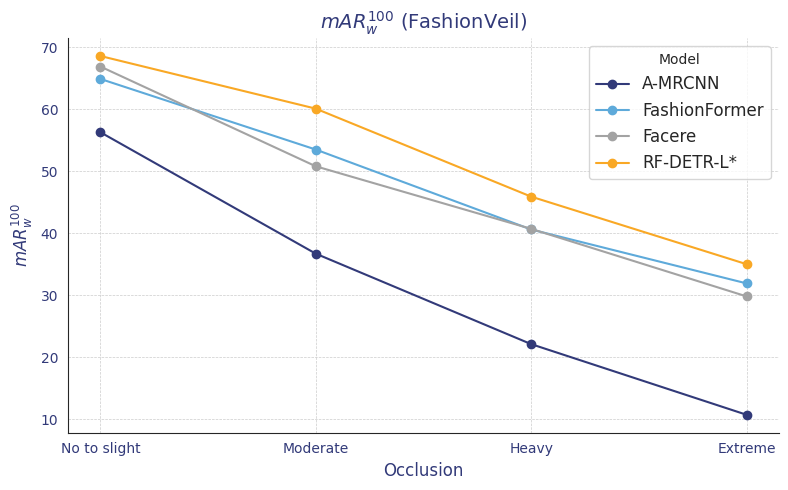

In [4]:
# ...existing code...
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data from the tables
occlusion_levels = ['No to slight', 'Moderate', 'Heavy', 'Extreme']

data = {
    'Occlusion': occlusion_levels,
    'A-MRCNN_mAPw':      [38.2, 20.0, 8.9, 2.7],
    'FashionFormer_mAPw':[44.8, 33.3, 20.3, 14.2],
    'Facere_mAPw':       [46.0, 30.1, 15.4, 9.6],
    'RF-DETR-L_mAPw':    [53.5, 43.8, 28.0, 15.8],

    'A-MRCNN_mAP50':      [59.2, 37.8, 23.0, 7.8],
    'FashionFormer_mAP50':[66.6, 61.0, 45.7, 35.6],
    'Facere_mAP50':       [65.7, 50.4, 33.3, 21.4],
    'RF-DETR-L_mAP50':    [68.6, 66.8, 52.8, 34.8],

    'A-MRCNN_mAP75':      [42.8, 20.9, 5.8, 1.1],
    'FashionFormer_mAP75':[49.2, 35.3, 15.8, 10.5],
    'Facere_mAP75':       [50.9, 31.4, 12.5, 7.4],
    'RF-DETR-L_mAP75':    [59.4, 49.0, 26.1, 13.7],

    'A-MRCNN_mAR1':      [40.5, 26.1, 18.7, 8.3],
    'FashionFormer_mAR1':[45.5, 40.0, 34.7, 25.8],
    'Facere_mAR1':       [46.8, 34.4, 29.8, 18.4],
    'RF-DETR-L_mAR1':    [48.9, 46.5, 40.0, 28.6],

    'A-MRCNN_mAR100':      [56.3, 36.7, 22.1, 10.7],
    'FashionFormer_mAR100':[64.9, 53.5, 40.6, 31.9],
    'Facere_mAR100':       [66.9, 50.8, 40.7, 29.8],
    'RF-DETR-L_mAR100':    [68.6, 60.1, 45.9, 35.0],
}

df = pd.DataFrame(data)

# ...existing code...
# Map display names to DataFrame prefixes
model_display_to_col = {
    "A-MRCNN": "A-MRCNN",
    "FashionFormer": "FashionFormer",
    "Facere": "Facere",
    "RF-DETR-L*": "RF-DETR-L"
}

model_colors = {
    "A-MRCNN": "#323a79",
    "FashionFormer": "#5EAADA",
    "Facere": "#A3A3A3",
    "RF-DETR-L*": "#F9A825"
}

sns.set_style("white")
metrics = [
    ("mAPw", "$mAP_w$"),
    ("mAP50", "$mAP^{@0.5}_w$"),
    ("mAP75", "$mAP^{@0.75}_w$"),
    ("mAR1", "$mAR^1_w$"),
    ("mAR100", "$mAR^{100}_w$")
]

for metric, metric_label in metrics:
    fig, ax = plt.subplots(figsize=(8,5))
    for model_display, color in model_colors.items():
        model_col = model_display_to_col[model_display]
        ax.plot(
            df["Occlusion"], 
            df[f"{model_col}_{metric}"], 
            marker='o', 
            label=model_display, 
            color=color
        )
    ax.set_xlabel("Occlusion", fontsize=12, color=colors["primary_dark"])
    ax.set_ylabel(metric_label, fontsize=12, color=colors["primary_dark"])
    ax.set_title(f"{metric_label} (FashionVeil)", fontsize=14, color=colors["primary_dark"])
    ax.tick_params(colors=colors["primary_dark"])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.legend(title="Model", fontsize=12)
    plt.tight_layout()
    plt.savefig(f'fashionveil_{metric}_occlusion.pdf')
    plt.show()
# ...existing code...


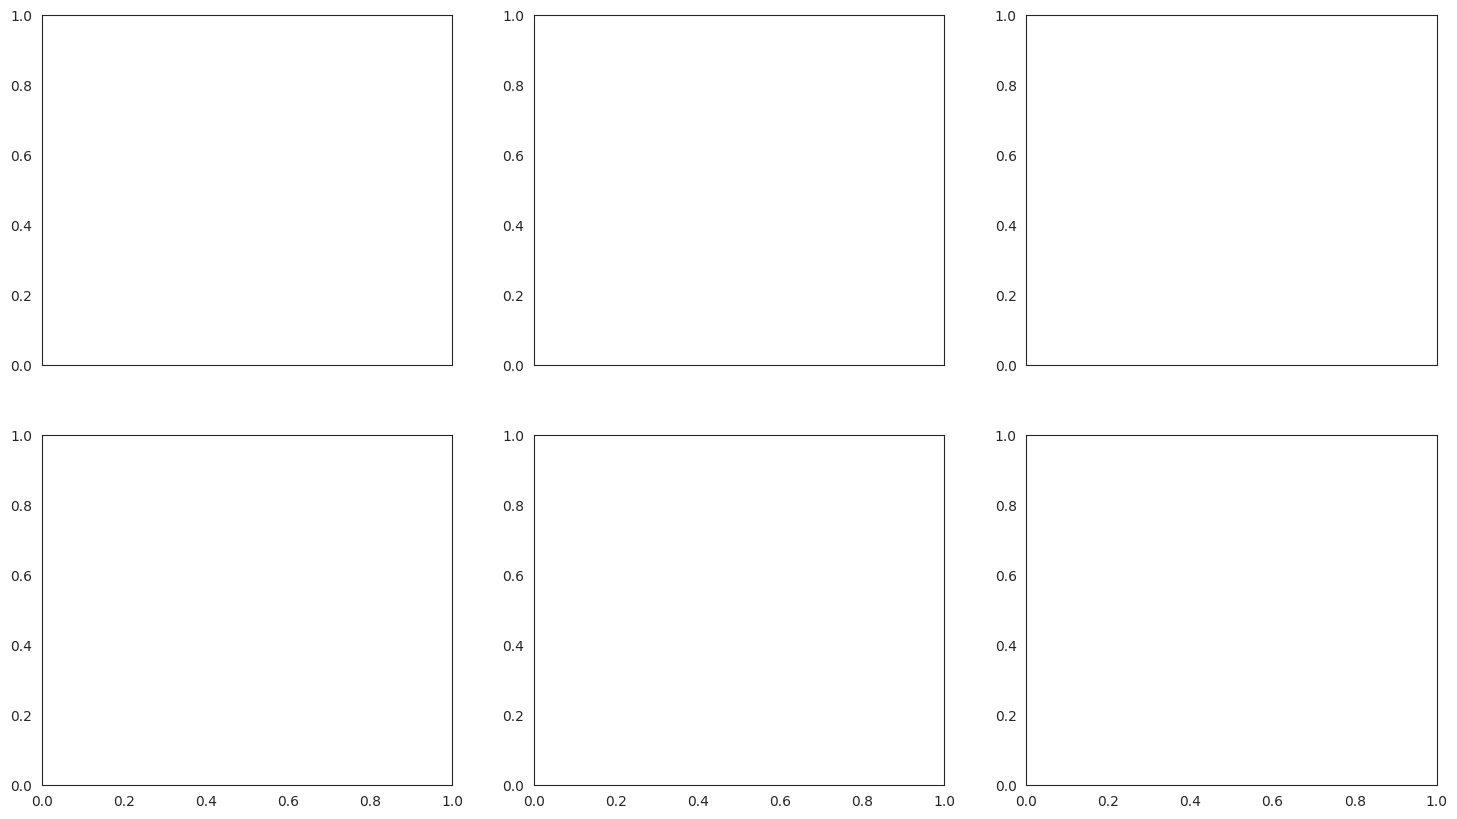

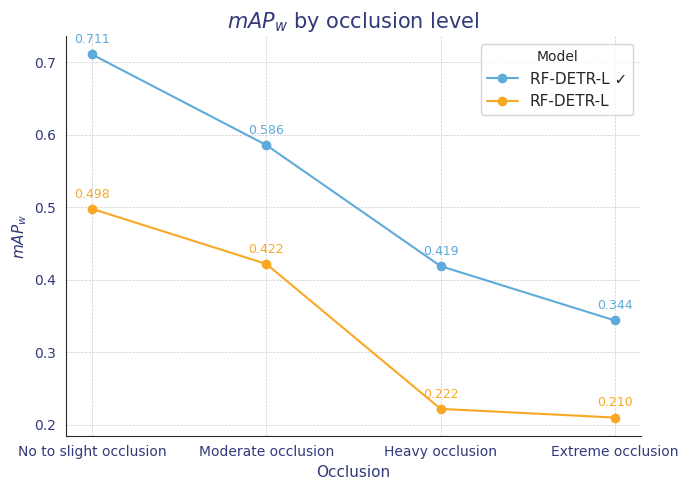

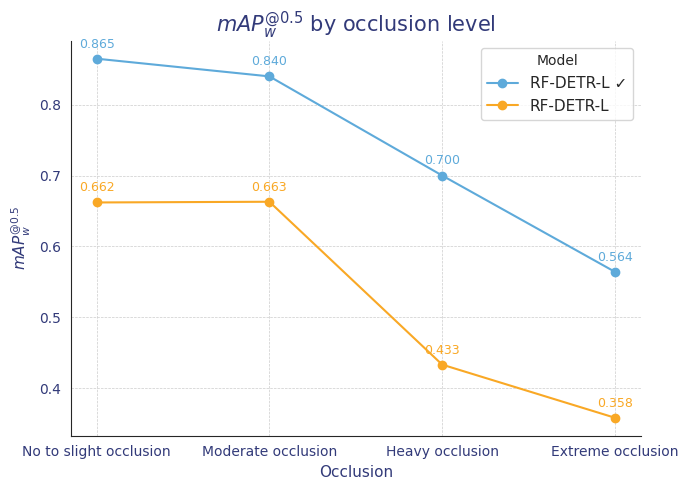

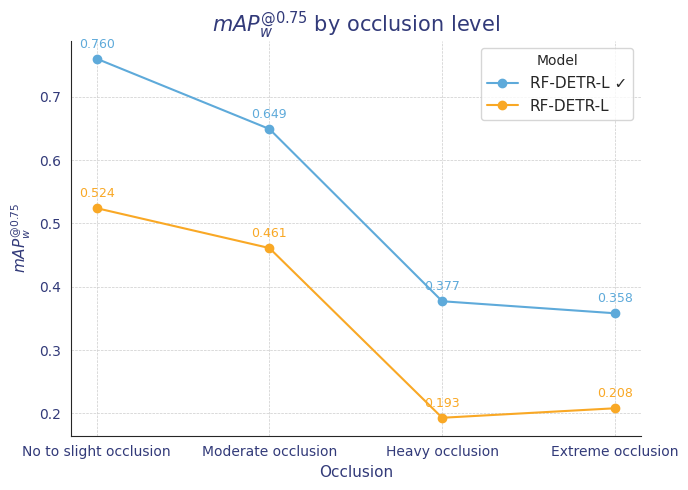

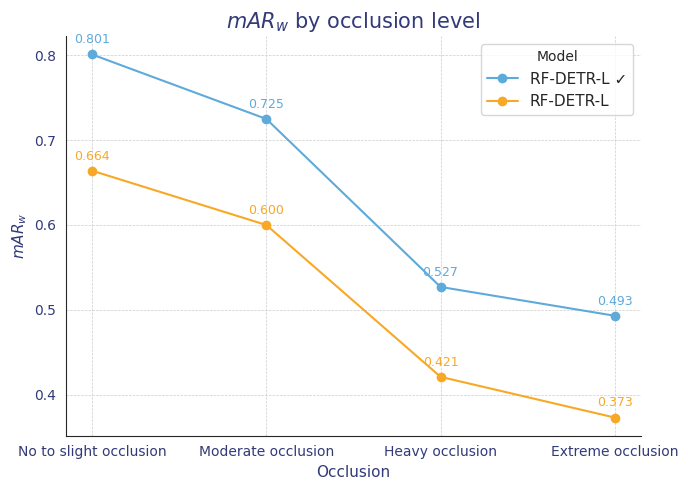

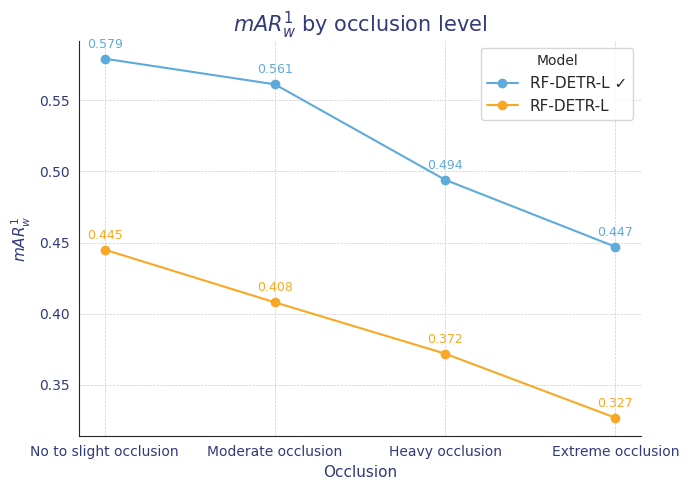

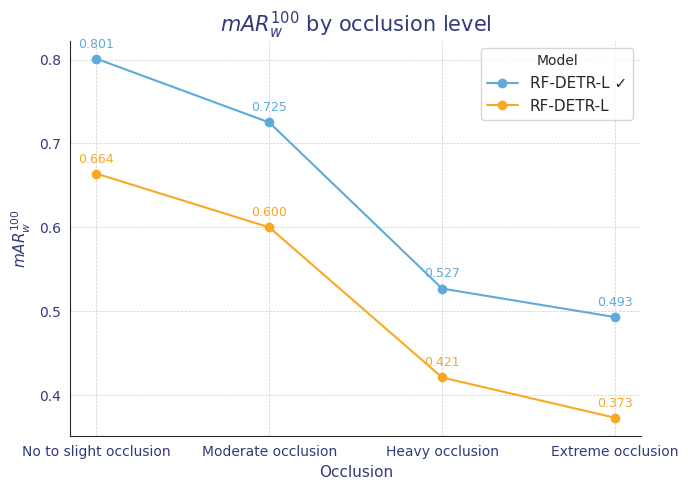

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data from your LaTeX tables
occlusion_levels = [
    "No to slight occlusion",
    "Moderate occlusion",
    "Heavy occlusion",
    "Extreme occlusion"
]

data = {
    "Occlusion": occlusion_levels,
    "RF-DETR✓_mAPw":    [0.711, 0.586, 0.419, 0.344],
    "RF-DETR-L_mAPw":   [0.498, 0.422, 0.222, 0.210],
    "RF-DETR✓_mAP50":   [0.865, 0.840, 0.700, 0.564],
    "RF-DETR-L_mAP50":  [0.662, 0.663, 0.433, 0.358],
    "RF-DETR✓_mAP75":   [0.760, 0.649, 0.377, 0.358],
    "RF-DETR-L_mAP75":  [0.524, 0.461, 0.193, 0.208],
    "RF-DETR✓_mARw":    [0.801, 0.725, 0.527, 0.493],
    "RF-DETR-L_mARw":   [0.664, 0.600, 0.421, 0.373],
    "RF-DETR✓_mAR1":    [0.579, 0.561, 0.494, 0.447],
    "RF-DETR-L_mAR1":   [0.445, 0.408, 0.372, 0.327],
    "RF-DETR✓_mAR100":  [0.801, 0.725, 0.527, 0.493],
    "RF-DETR-L_mAR100": [0.664, 0.600, 0.421, 0.373],
}

df = pd.DataFrame(data)

model_display_to_col = {
    "RF-DETR-L ✓": "RF-DETR✓",
    "RF-DETR-L": "RF-DETR-L"
}
model_colors = {
    "RF-DETR-L ✓": "#5EAADA",
    "RF-DETR-L": "#F9A825"
}

metrics = [
    ("mAPw", "$mAP_w$"),
    ("mAP50", "$mAP^{@0.5}_w$"),
    ("mAP75", "$mAP^{@0.75}_w$"),
    ("mARw", "$mAR_w$"),
    ("mAR1", "$mAR^1_w$"),
    ("mAR100", "$mAR^{100}_w$")
]

sns.set_style("white")

fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True)
axes = axes.flatten()

for idx, (metric, metric_label) in enumerate(metrics):
    fig, ax = plt.subplots(figsize=(7, 5))
    for model_display, color in model_colors.items():
        model_col = model_display_to_col[model_display]
        ax.plot(
            df["Occlusion"],
            df[f"{model_col}_{metric}"],
            marker='o',
            label=model_display,
            color=color
        )
        # Annotate points
        for x, y in zip(df["Occlusion"], df[f"{model_col}_{metric}"]):
            ax.annotate(f'{y:.3f}', (x, y), textcoords="offset points", xytext=(0, 8),
                        ha='center', fontsize=9, color=color)
    ax.set_xlabel("Occlusion", fontsize=11, color="#323a79")
    ax.set_ylabel(metric_label, fontsize=11, color="#323a79")
    ax.tick_params(colors="#323a79")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True, linestyle='--', linewidth=0.5)
    ax.legend(title="Model", fontsize=11)
    ax.set_title(f"{metric_label} by occlusion level", fontsize=15, color="#323a79")
    plt.tight_layout()
    plt.savefig(f'fashionveil_{metric}_occlusion_rfdetr.pdf')
    plt.show()


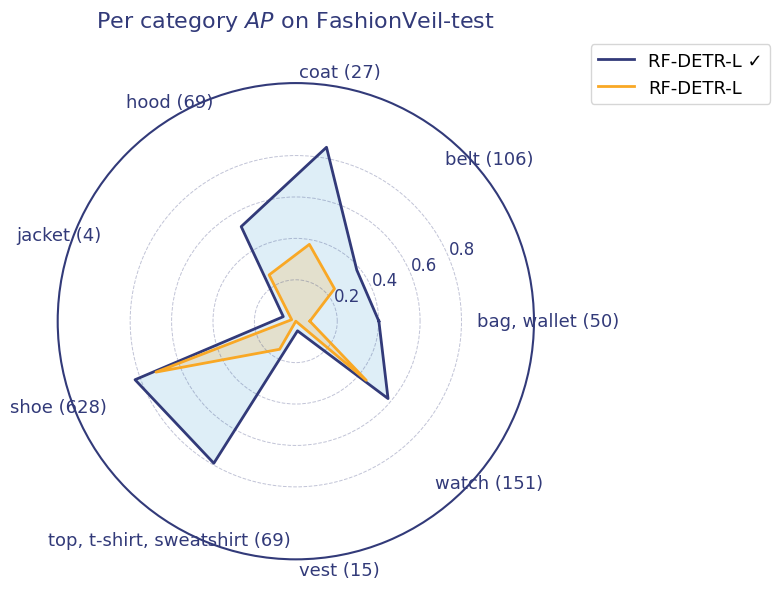

In [29]:
# ...existing code...

# Categories and counts (nonzero only, in order)
categories_with_counts_nonzero = [
    "bag, wallet (50)", "belt (106)", "coat (27)", "hood (69)", "jacket (4)",
    "shoe (628)", "top, t-shirt, sweatshirt (69)", "vest (15)", "watch (151)"
]

# Angles for radar plot (one per category + closing the circle)
import numpy as np
num_vars = len(categories_with_counts_nonzero)
angles_nonzero = np.linspace(0, 2 * np.pi, num_vars + 1)

# AP values for RF-DETR-L ✓ (checkmark) and RF-DETR-L (no checkmark), nonzero classes only
ap_values_new_nonzero = [
    0.400975, 0.384311, 0.852959, 0.527647, 0.064356, 0.826292, 0.792076, 0.047129, 0.581319
]
ap_values_new_nonzero = ap_values_new_nonzero + [ap_values_new_nonzero[0]]

ap_values_name_nonzero = [
    0.067605, 0.243784, 0.376748, 0.258185, 0.021452, 0.718865, 0.156533, 0.0, 0.443898
]
ap_values_name_nonzero_cycle = ap_values_name_nonzero + [ap_values_name_nonzero[0]]

# ...existing code...

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.plot(angles_nonzero, ap_values_new_nonzero, label='RF-DETR-L ✓', color=colors["primary_dark"], linewidth=2)
ax.fill(angles_nonzero, ap_values_new_nonzero, color=colors["primary_light"], alpha=0.2)

ax.plot(angles_nonzero, ap_values_name_nonzero_cycle, label='RF-DETR-L', color="#F9A825", linewidth=2)
ax.fill(angles_nonzero, ap_values_name_nonzero_cycle, color="#F9A825", alpha=0.2)

# Move labels well outside the plot and keep them horizontal
radius_for_labels = 1.22  # increase this value to move labels further out
for label, angle in zip(categories_with_counts_nonzero, angles_nonzero[:-1]):
    ax.text(
        angle,
        radius_for_labels,
        label,
        size=13,
        color=colors["primary_dark"],
        horizontalalignment='center',
        verticalalignment='center',
        rotation=0,  # horizontal
        rotation_mode='anchor'
    )

ax.set_xticks([])  # Remove default x-tick labels
ax.set_yticks([0.2, 0.4, 0.6, 0.8])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8'], color=colors["primary_dark"], fontsize=12)
ax.set_ylim(0, 1.15)
ax.tick_params(axis='y', colors=colors["primary_dark"])
ax.spines['polar'].set_color(colors["primary_dark"])
ax.spines['polar'].set_linewidth(1.5)
fig.patch.set_facecolor(colors["white"])
ax.grid(True, linestyle='--', linewidth=0.7, color=colors["primary_dark"], alpha=0.3)

plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1.1), fontsize=13)
plt.title('Per category $AP$ on FashionVeil-test', color=colors["primary_dark"], fontsize=16, y=1.10)
plt.tight_layout()
plt.savefig('fashionveil_test_radar_plot.pdf', bbox_inches='tight', dpi=300)
plt.show()

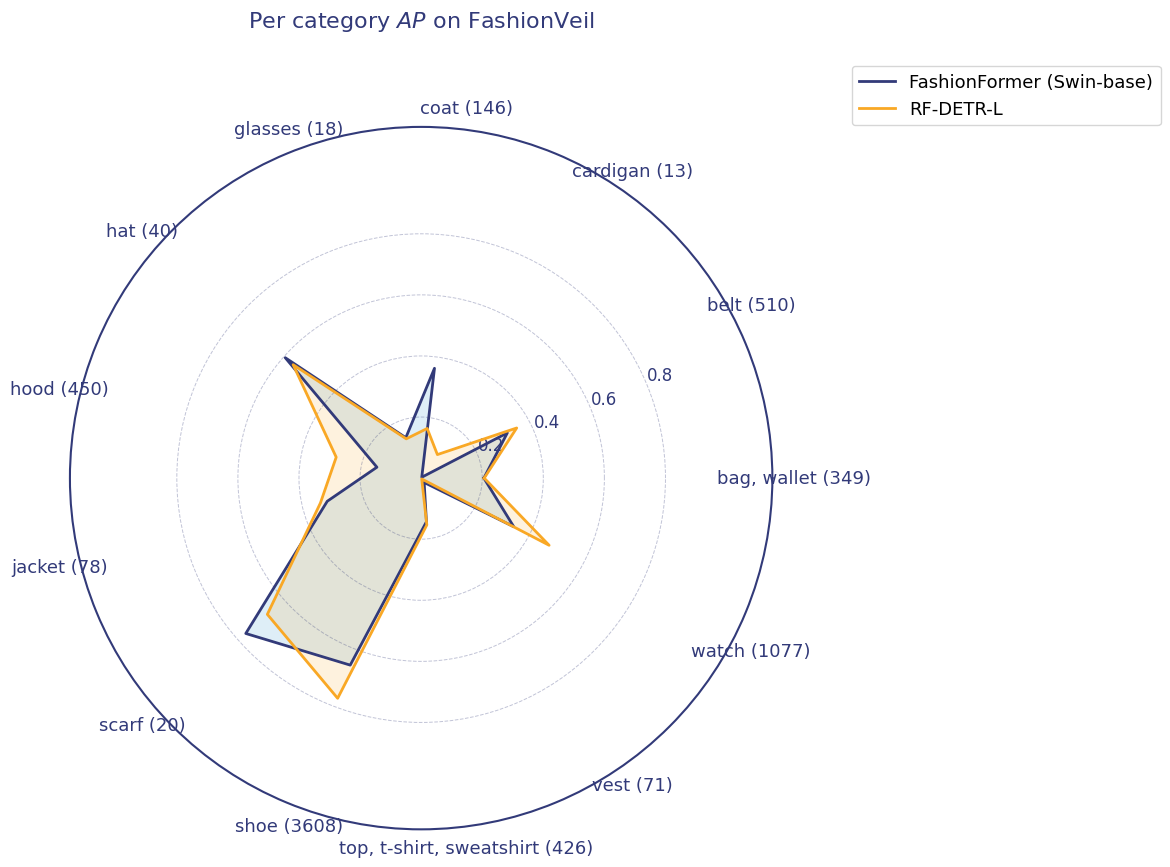

In [33]:
#

categories_with_counts = [
    "bag, wallet (349)", "belt (510)", "cardigan (13)", "coat (146)", "glasses (18)", "hat (40)",
    "hood (450)", "jacket (78)", "scarf (20)", "shoe (3608)", "top, t-shirt, sweatshirt (426)", "vest (71)", "watch (1077)"
]

ap_values_fashionformer = [
    0.205406, 0.318682, 0.003600, 0.362238, 0.141470, 0.594592,
    0.149153, 0.316629, 0.767112, 0.654863, 0.143833, 0.017288, 0.342477
]

ap_values_rfdetr_l = [
    0.206481, 0.353255, 0.093609, 0.163709, 0.137540, 0.559977,
    0.286442, 0.339592, 0.672778, 0.771028, 0.154366, 0.003300, 0.473188
]

# For radar plot, close the circle
categories_with_counts_cycle = categories_with_counts + [categories_with_counts[0]]
ap_values_fashionformer_cycle = ap_values_fashionformer + [ap_values_fashionformer[0]]
ap_values_rfdetr_l_cycle = ap_values_rfdetr_l + [ap_values_rfdetr_l[0]]

num_vars = len(categories_with_counts)
angles = np.linspace(0, 2 * np.pi, num_vars + 1)

fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(polar=True))
ax.plot(angles, ap_values_fashionformer_cycle, label='FashionFormer (Swin-base)', color=colors["primary_dark"], linewidth=2)
ax.fill(angles, ap_values_fashionformer_cycle, color=colors["primary_light"], alpha=0.2)

ax.plot(angles, ap_values_rfdetr_l_cycle, label='RF-DETR-L', color="#F9A825", linewidth=2)
ax.fill(angles, ap_values_rfdetr_l_cycle, color="#F9A825", alpha=0.15)

# Move labels well outside the plot and keep them horizontal
radius_for_labels = 1.22
for label, angle in zip(categories_with_counts, angles[:-1]):
    ax.text(
        angle,
        radius_for_labels,
        label,
        size=13,
        color=colors["primary_dark"],
        horizontalalignment='center',
        verticalalignment='center',
        rotation=0,
        rotation_mode='anchor'
    )

ax.set_xticks([])
ax.set_yticks([0.2, 0.4, 0.6, 0.8])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8'], color=colors["primary_dark"], fontsize=12)
ax.set_ylim(0, 1.15)
ax.tick_params(axis='y', colors=colors["primary_dark"])
ax.spines['polar'].set_color(colors["primary_dark"])
ax.spines['polar'].set_linewidth(1.5)
fig.patch.set_facecolor(colors["white"])
ax.grid(True, linestyle='--', linewidth=0.7, color=colors["primary_dark"], alpha=0.3)

plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1.1), fontsize=13)
plt.title('Per category $AP$ on FashionVeil', color=colors["primary_dark"], fontsize=16, y=1.13)
plt.tight_layout()
plt.savefig('fashionveil_all_radar_plot.pdf', bbox_inches='tight', dpi=300)
plt.show()


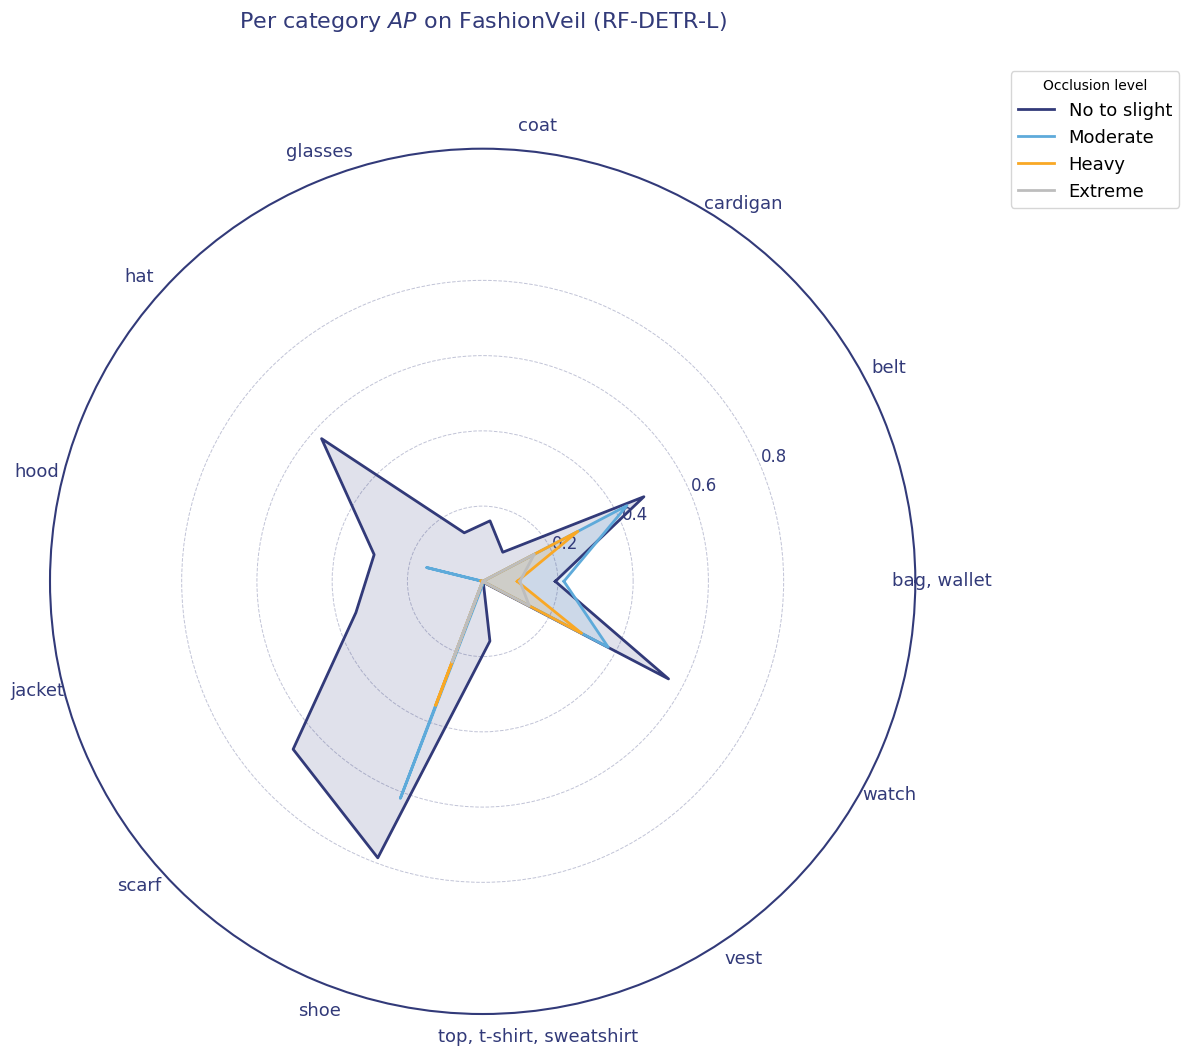

In [37]:
# Remove counts from categories_with_counts
categories_no_counts = [cat.split(' (')[0] for cat in categories_with_counts]

# For radar plot, close the circle
categories_no_counts_cycle = categories_no_counts + [categories_no_counts[0]]
# ...existing code...

ap_values_no_to_slight_occlusion = [
    0.193,  # bag, wallet
    0.484,  # belt
    0.094,  # cardigan
    0.162,  # coat
    0.138,  # glasses
    0.572,  # hat
    0.297,  # hood
    0.347,  # jacket
    0.673,  # scarf
    0.786,  # shoe
    0.160,  # top, t-shirt, sweatshirt
    0.003,  # vest
    0.558   # watch
]

ap_values_moderate_occlusion = [
    0.216,  # bag, wallet
    0.433,  # belt
    0.000,  # cardigan
    0.000,  # coat
    0.000,  # glasses
    0.000,  # hat
    0.153,  # hood
    0.000,  # jacket
    0.000,  # scarf
    0.617,  # shoe
    0.007,  # top, t-shirt, sweatshirt
    0.000,  # vest
    0.377   # watch
]

ap_values_heavy_occlusion = [
    0.092,  # bag, wallet
    0.286,  # belt
    0.000,  # cardigan
    0.000,  # coat
    0.000,  # glasses
    0.000,  # hat
    0.005,  # hood
    0.000,  # jacket
    0.000,  # scarf
    0.352,  # shoe
    0.000,  # top, t-shirt, sweatshirt
    0.000,  # vest
    0.297   # watch
]

ap_values_extreme_occlusion = [
    0.099,  # bag, wallet
    0.155,  # belt
    0.000,  # cardigan
    0.000,  # coat
    0.000,  # glasses
    0.000,  # hat
    0.000,  # hood
    0.000,  # jacket
    0.000,  # scarf
    0.229,  # shoe
    0.000,  # top, t-shirt, sweatshirt
    0.000,  # vest
    0.140   # watch
]

# ...existing code...
# Example: plotting all occlusion levels
ap_levels = {
    "No to slight": ap_values_no_to_slight_occlusion,
    "Moderate": ap_values_moderate_occlusion,
    "Heavy": ap_values_heavy_occlusion,
    "Extreme": ap_values_extreme_occlusion
}
colors_occlusion = ["#323a79", "#5EAADA", "#F9A825", "#BDBDBD"]

num_vars = len(categories_no_counts)
angles = np.linspace(0, 2 * np.pi, num_vars + 1)

fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(polar=True))

for (label, ap_vals), color in zip(ap_levels.items(), colors_occlusion):
    ap_cycle = ap_vals + [ap_vals[0]]
    ax.plot(angles, ap_cycle, label=label, color=color, linewidth=2)
    ax.fill(angles, ap_cycle, color=color, alpha=0.15)

# Move labels well outside the plot and keep them horizontal
radius_for_labels = 1.22
for label, angle in zip(categories_no_counts, angles[:-1]):
    ax.text(
        angle,
        radius_for_labels,
        label,
        size=13,
        color=colors["primary_dark"],
        horizontalalignment='center',
        verticalalignment='center',
        rotation=0,
        rotation_mode='anchor'
    )

ax.set_xticks([])
ax.set_yticks([0.2, 0.4, 0.6, 0.8])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8'], color=colors["primary_dark"], fontsize=12)
ax.set_ylim(0, 1.15)
ax.tick_params(axis='y', colors=colors["primary_dark"])
ax.spines['polar'].set_color(colors["primary_dark"])
ax.spines['polar'].set_linewidth(1.5)
fig.patch.set_facecolor(colors["white"])
ax.grid(True, linestyle='--', linewidth=0.7, color=colors["primary_dark"], alpha=0.3)

plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1.1), fontsize=13, title="Occlusion level")
plt.title('Per category $AP$ on FashionVeil (RF-DETR-L)', color=colors["primary_dark"], fontsize=16, y=1.13)
plt.tight_layout()
plt.savefig('fashionveil_occlusion_radar_plot.pdf', bbox_inches='tight', dpi=300)
plt.show()


Object counts per category and occlusion level:


,Category,Overall,No to slight,Moderate,Heavy,Extreme
0,"bag, wallet",50,38,10,2,0
1,belt,106,24,25,25,32
2,cardigan,0,0,0,0,0
3,coat,27,27,0,0,0
4,glasses,0,0,0,0,0
5,hat,0,0,0,0,0
6,hood,69,29,35,5,0
7,jacket,4,4,0,0,0
8,scarf,0,0,0,0,0
9,shoe,628,540,69,14,5


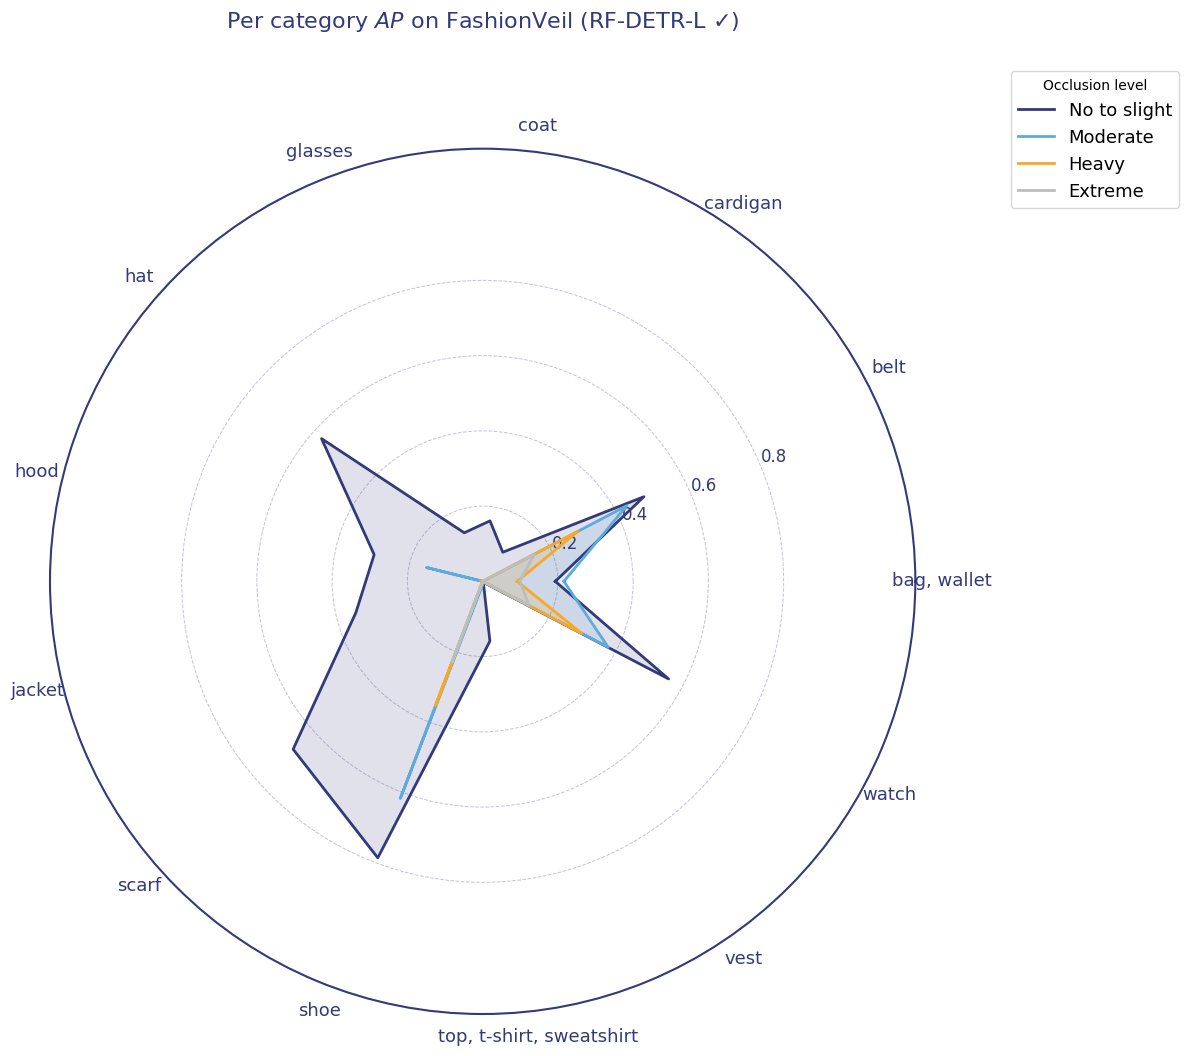

In [39]:
# Remove counts from categories_with_counts
categories_no_counts = [cat.split(' (')[0] for cat in categories_with_counts]

# For radar plot, close the circle
categories_no_counts_cycle = categories_no_counts + [categories_no_counts[0]]
# ...existing code...

categories = [
    "bag, wallet", "belt", "cardigan", "coat", "glasses", "hat",
    "hood", "jacket", "scarf", "shoe", "top, t-shirt, sweatshirt", "vest", "watch"
]

ap_no_to_slight = [
    0.366,  # bag, wallet
    0.480,  # belt
    0.000,  # cardigan
    0.853,  # coat
    0.000,  # glasses
    0.000,  # hat
    0.388,  # hood
    0.064,  # jacket
    0.000,  # scarf
    0.838,  # shoe
    0.798,  # top, t-shirt, sweatshirt
    0.066,  # vest
    0.630   # watch
]

ap_moderate = [
    0.213,  # bag, wallet
    0.442,  # belt
    0.000,  # cardigan
    0.000,  # coat
    0.000,  # glasses
    0.000,  # hat
    0.629,  # hood
    0.000,  # jacket
    0.000,  # scarf
    0.770,  # shoe
    0.000,  # top, t-shirt, sweatshirt
    0.000,  # vest
    0.502   # watch
]

ap_heavy = [
    0.000,  # bag, wallet
    0.405,  # belt
    0.000,  # cardigan
    0.000,  # coat
    0.000,  # glasses
    0.000,  # hat
    0.110,  # hood
    0.000,  # jacket
    0.000,  # scarf
    0.657,  # shoe
    0.000,  # top, t-shirt, sweatshirt
    0.000,  # vest
    0.455   # watch
]

ap_extreme = [
    0.000,  # bag, wallet
    0.238,  # belt
    0.000,  # cardigan
    0.000,  # coat
    0.000,  # glasses
    0.000,  # hat
    0.000,  # hood
    0.000,  # jacket
    0.000,  # scarf
    0.558,  # shoe
    0.000,  # top, t-shirt, sweatshirt
    0.000,  # vest
    0.474   # watch
]
# ...existing code...

# --- Add object counts overall and per occlusion level ---

categories_no_counts = [
    "bag, wallet", "belt", "cardigan", "coat", "glasses", "hat",
    "hood", "jacket", "scarf", "shoe", "top, t-shirt, sweatshirt", "vest", "watch"
]

# Overall object counts (from your logs or annotation stats)
object_counts_overall = [50, 106, 0, 27, 0, 0, 69, 4, 0, 628, 69, 15, 151]

# Per occlusion level (from your logs)
object_counts_no_to_slight = [38, 24, 0, 27, 0, 0, 29, 4, 0, 540, 69, 11, 95]
object_counts_moderate = [10, 25, 0, 0, 0, 0, 35, 0, 0, 69, 0, 1, 20]
object_counts_heavy = [2, 25, 0, 0, 0, 0, 5, 0, 0, 14, 0, 3, 18]
object_counts_extreme = [0, 32, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 18]

object_counts_per_occlusion = {
    "No to slight": object_counts_no_to_slight,
    "Moderate": object_counts_moderate,
    "Heavy": object_counts_heavy,
    "Extreme": object_counts_extreme
}

# Print as a table for quick reference
import pandas as pd

df_counts = pd.DataFrame({
    "Category": categories_no_counts,
    "Overall": object_counts_overall,
    "No to slight": object_counts_no_to_slight,
    "Moderate": object_counts_moderate,
    "Heavy": object_counts_heavy,
    "Extreme": object_counts_extreme
})
print("Object counts per category and occlusion level:")
display(df_counts)

# ...existing code for radar plot...
# ...existing code...
# Example: plotting all occlusion levels
ap_levels = {
    "No to slight": ap_values_no_to_slight_occlusion,
    "Moderate": ap_values_moderate_occlusion,
    "Heavy": ap_values_heavy_occlusion,
    "Extreme": ap_values_extreme_occlusion
}
colors_occlusion = ["#323a79", "#5EAADA", "#F9A825", "#BDBDBD"]

num_vars = len(categories_no_counts)
angles = np.linspace(0, 2 * np.pi, num_vars + 1)

fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(polar=True))

for (label, ap_vals), color in zip(ap_levels.items(), colors_occlusion):
    ap_cycle = ap_vals + [ap_vals[0]]
    ax.plot(angles, ap_cycle, label=label, color=color, linewidth=2)
    ax.fill(angles, ap_cycle, color=color, alpha=0.15)

# Move labels well outside the plot and keep them horizontal
radius_for_labels = 1.22
for label, angle in zip(categories_no_counts, angles[:-1]):
    ax.text(
        angle,
        radius_for_labels,
        label,
        size=13,
        color=colors["primary_dark"],
        horizontalalignment='center',
        verticalalignment='center',
        rotation=0,
        rotation_mode='anchor'
    )

ax.set_xticks([])
ax.set_yticks([0.2, 0.4, 0.6, 0.8])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8'], color=colors["primary_dark"], fontsize=12)
ax.set_ylim(0, 1.15)
ax.tick_params(axis='y', colors=colors["primary_dark"])
ax.spines['polar'].set_color(colors["primary_dark"])
ax.spines['polar'].set_linewidth(1.5)
fig.patch.set_facecolor(colors["white"])
ax.grid(True, linestyle='--', linewidth=0.7, color=colors["primary_dark"], alpha=0.3)

plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1.1), fontsize=13, title="Occlusion level")
plt.title('Per category $AP$ on FashionVeil (RF-DETR-L ✓)', color=colors["primary_dark"], fontsize=16, y=1.13)
plt.tight_layout()
plt.savefig('fashionveil_occlusion_test_radar_plot.pdf', bbox_inches='tight', dpi=300)
plt.show()
